# Soccer World Cup 2018 Winner

In [291]:
from IPython.display import Image

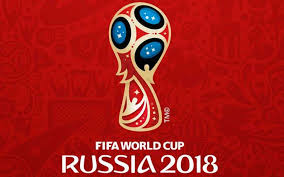

In [292]:
Image(filename ='wcrussia.jpg')

## Overview
(*Kaggle_Predicting the winner of the 2018 FIFA Wolrdcup 참고 https://www.kaggle.com/agostontorok/soccer-world-cup-2018-winner/notebook *)

+ AIm : 2018 러시아 월드컵 결과를 예측해보자<br>


* Data(from kaggle) <br>
    >1.FIFA rankings from 1993 to 2018 <br>
    2.International Soccer matches from 1897 to 2018<br>
    3.FIFa worldcup 2018 data set<br>
    
* Modeling
    >1.Baseline : Kaggle model 처럼 logistic을 기본모델로 설정
     2.SVM 
     3.Xgboost
     4.RandomForest
     5.NeuralNet

* 결과 --> Visualization(kaggle 참고)

### Preprocessing

In [293]:
%cd C:\Users\hanbum\Desktop\2018\work\2. Project\3. Personal\worldcup18
%pwd

C:\Users\hanbum\Desktop\2018\work\2. Project\3. Personal\worldcup18


'C:\\Users\\hanbum\\Desktop\\2018\\work\\2. Project\\3. Personal\\worldcup18'

In [426]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt

%matplotlib inline

In [376]:
# load data

rankings = pd.read_csv('fifa_ranking.csv', encoding ='utf-8')
matches = pd.read_csv('results.csv')
fifa18 = pd.read_csv('World Cup 2018 Dataset.csv', encoding = 'utf-8')

In [296]:
# 필요한 column만 선택 
print(rankings.columns)
rankings2 = rankings.copy()

rankings2 = rankings2.iloc[:,np.r_[0:3,7,11,13,15]]

Index(['rank', 'country_full', 'country_abrv', 'total_points',
       'previous_points', 'rank_change', 'cur_year_avg',
       'cur_year_avg_weighted', 'last_year_avg', 'last_year_avg_weighted',
       'two_year_ago_avg', 'two_year_ago_weighted', 'three_year_ago_avg',
       'three_year_ago_weighted', 'confederation', 'rank_date'],
      dtype='object')


In [302]:
# Iran 풀네임 바꿔주기

rankings2[rankings2.country_full == 'IR Iran']
rankings2 = rankings2.replace({'IR Iran' :'Iran'})

In [306]:
# weighted 파생변수 만들기

rankings2['weighted_points'] = rankings2['cur_year_avg_weighted']+rankings2['two_year_ago_weighted']+rankings2['three_year_ago_weighted']

In [307]:
# date형으로 type 변환

rankings2['rank_date'] = pd.to_datetime(rankings2['rank_date'])

In [377]:
matches.head()

,date,home_team,away_team,home_score,away_score,tournament,city,country,neutral
0,1872-11-30,Scotland,England,0,0,Friendly,Glasgow,Scotland,False
1,1873-03-08,England,Scotland,4,2,Friendly,London,England,False
2,1874-03-07,Scotland,England,2,1,Friendly,Glasgow,Scotland,False
3,1875-03-06,England,Scotland,2,2,Friendly,London,England,False
4,1876-03-04,Scotland,England,3,0,Friendly,Glasgow,Scotland,False


In [378]:
# 나라명 통일 해주기

matches2 = matches.copy()
matches2 = matches2.replace({'Germany DR':'Germany', 'China':'China PR'})

In [379]:
# date형으로 type 변환

matches2['date'] = pd.to_datetime(matches2['date'])

In [353]:
fifa182 = fifa18.copy()

In [354]:
fifa182 = fifa182.loc[:,['Team', 'Group', 'First match \nagainst', 'Second match\n against', 'Third match\n against']]

In [355]:
#missing value 있는 칼럼합 출력

fifa182.isnull().sum()

Team                      1
Group                     1
First match \nagainst     1
Second match\n against    1
Third match\n against     1
dtype: int64

In [356]:
#missing value 있는 rows만 출력
fifa182[fifa182.isnull().any(axis=1)]

,Team,Group,First match against,Second match against,Third match against
32,NaN,NaN,NaN,NaN,NaN


In [357]:
# missing value 있는 행 삭제

fifa182 = fifa182.dropna(how='all')

In [358]:
fifa182 = fifa182.replace({"IRAN": "Iran", 
                               "Costarica": "Costa Rica", 
                               "Porugal": "Portugal", 
                               "Columbia": "Colombia", 
                               "Korea" : "Korea Republic"})

In [363]:
fifa182 = fifa182.set_index('Team')

In [364]:
fifa182.head()

,Group,First match against,Second match against,Third match against
Team,,,,
Russia,A,Saudi Arabia,Egypt,Uruguay
Saudi Arabia,A,Russia,Uruguay,Egypt
Egypt,A,Uruguay,Russia,Saudi Arabia
Uruguay,A,Egypt,Saudi Arabia,Russia
Portugal,B,Spain,Morocco,Iran


In [366]:
# I want to have the ranks for every day 
rankings2 = rankings2.set_index(['rank_date'])\
            .groupby(['country_full'], group_keys=False)\
            .resample('D').first()\
            .fillna(method='ffill')\
            .reset_index()

In [380]:
# join the ranks
matches2 = matches2.merge(rankings2, 
                        left_on=['date', 'home_team'], 
                        right_on=['rank_date', 'country_full'])

matches2 = matches2.merge(rankings2, 
                        left_on=['date', 'away_team'], 
                        right_on=['rank_date', 'country_full'], 
                        suffixes=('_home', '_away'))

In [388]:
# feature generation
matches2['rank_difference'] = matches2['rank_home'] - matches2['rank_away']

matches2['average_rank'] = (matches2['rank_home'] + matches2['rank_away'])/2

matches2['point_difference'] = matches2['weighted_points_home'] - matches2['weighted_points_away']

matches2['score_difference'] = matches2['home_score'] - matches2['away_score']

matches2['is_won'] = matches2['score_difference'] > 0 # take draw as lost

matches2['is_stake'] = matches2['tournament'] != 'Friendly'

In [392]:
# I tried earlier rest days but it did not turn to be useful
max_rest = 30
matches2['rest_days'] = matches2.groupby('home_team').diff()['date'].dt.days.clip(0,max_rest).fillna(max_rest)

# I tried earlier the team as well but that did not make a difference either
matches2['wc_participant'] = matches2['home_team'] * matches2['home_team'].isin(fifa182.index.tolist())

matches2['wc_participant'] = matches2['wc_participant'].replace({'':'Other'})

matches = matches.join(pd.get_dummies(matches2['wc_participant']))

# Modeling

In [393]:
from sklearn import linear_model
from sklearn import ensemble
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures

In [403]:
X, y = matches2.loc[:,['average_rank', 'rank_difference', 'point_difference', 'is_stake']], matches2['is_won']
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42)

logreg = linear_model.LogisticRegression(C=1e-5)
features = PolynomialFeatures(degree=2)

model = Pipeline([
    ('polynomial_features', features),
    ('logistic_regression', logreg)
])

model = model.fit(X_train, y_train)

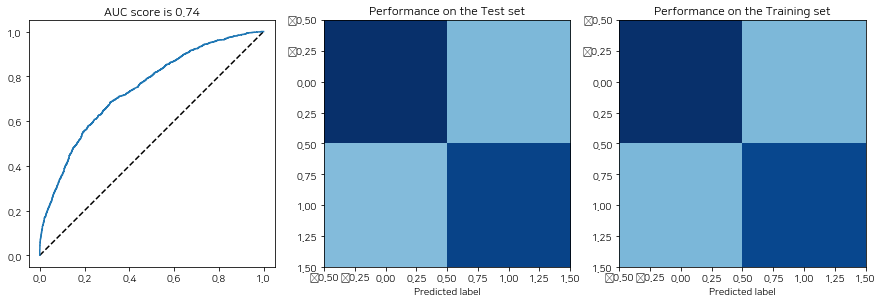

In [427]:
# figures 
fpr, tpr, _ = roc_curve(y_test, model.predict_proba(X_test)[:,1])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.plot([0, 1], [0, 1], 'k--')
ax.plot(fpr, tpr)
ax.set_title('AUC score is {0:0.2}'.format(roc_auc_score(y_test, model.predict_proba(X_test)[:,1])))
ax.set_aspect(1)

ax = plt.subplot(1,3,2)
cm = confusion_matrix(y_test, model.predict(X_test))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 

ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Test set')

ax = plt.subplot(1,3,3)
cm = confusion_matrix(y_train, model.predict(X_train))
ax.imshow(cm, cmap='Blues', clim = (0, cm.max())) 
ax.set_xlabel('Predicted label')
ax.set_title('Performance on the Training set')
pass

Stakes distribution in the wrong predictions
True     0.578231
False    0.421769
Name: is_stake, dtype: float64
Stakes distribution overall
True     0.615618
False    0.384382
Name: is_stake, dtype: float64


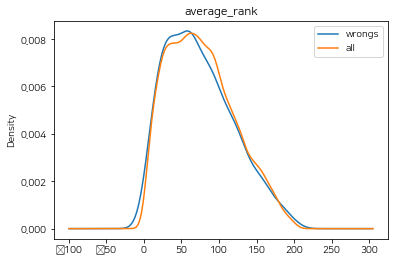

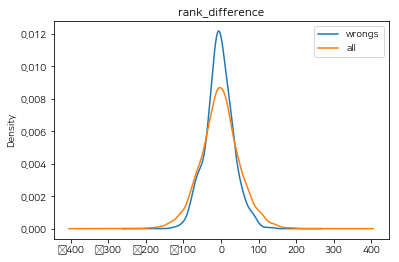

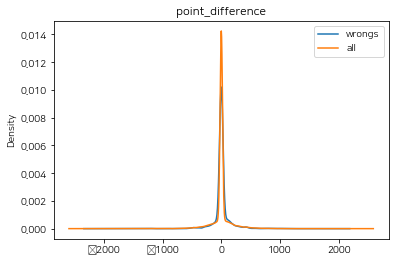

In [428]:
features = ['average_rank', 'rank_difference', 'point_difference']
wrongs = y_test != model.predict(X_test)

for feature in features:
    plt.figure()
    plt.title(feature)
    X_test.loc[wrongs, feature].plot.kde()
    X.loc[:, feature].plot.kde()
    plt.legend(['wrongs', 'all'])
    
print("Stakes distribution in the wrong predictions")
print(X_test.loc[wrongs, 'is_stake'].value_counts() / wrongs.sum())
print("Stakes distribution overall")
print(X['is_stake'].value_counts() / X.shape[0])

### worldcup prediction

In [430]:
# let's define a small margin when we safer to predict draw then win
margin = 0.05

# let's define the rankings at the time of the World Cup
world_cup_rankings = rankings2.loc[(rankings2['rank_date'] == rankings2['rank_date'].max()) & 
                                    rankings2['country_full'].isin(fifa182.index.unique())]
world_cup_rankings = world_cup_rankings.set_index(['country_full'])

In [433]:
from itertools import combinations

opponents = ['First match \nagainst', 'Second match\n against', 'Third match\n against']

fifa182['points'] = 0
fifa182['total_prob'] = 0

for group in set(fifa182['Group']):
    print('___Starting group {}:___'.format(group))
    for home, away in combinations(fifa182.query('Group == "{}"'.format(group)).index, 2):
        print("{} vs. {}: ".format(home, away), end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        fifa182.loc[home, 'total_prob'] += home_win_prob
        fifa182.loc[away, 'total_prob'] += 1-home_win_prob
        points = 0
        if home_win_prob <= 0.5 - margin:
            print("{} wins with {:.2f}".format(away, 1-home_win_prob))
            fifa182.loc[away, 'points'] += 3
        if home_win_prob > 0.5 - margin:
            points = 1
        if home_win_prob >= 0.5 + margin:
            points = 3
            fifa182.loc[home, 'points'] += 3
            print("{} wins with {:.2f}".format(home, home_win_prob))
        if points == 1:
            print("Draw")
            fifa182.loc[home, 'points'] += 1
            fifa182.loc[away, 'points'] += 1

___Starting group A:___
Russia vs. Saudi Arabia: Saudi Arabia wins with 0.55
Russia vs. Egypt: Egypt wins with 0.66
Russia vs. Uruguay: Uruguay wins with 0.83
Saudi Arabia vs. Egypt: Egypt wins with 0.65
Saudi Arabia vs. Uruguay: Uruguay wins with 0.83
Egypt vs. Uruguay: Uruguay wins with 0.74
___Starting group E:___
Brazil vs. Switzerland: Draw
Brazil vs. Costa Rica: Brazil wins with 0.62
Brazil vs. Serbia: Brazil wins with 0.67
Switzerland vs. Costa Rica: Switzerland wins with 0.59
Switzerland vs. Serbia: Switzerland wins with 0.65
Costa Rica vs. Serbia: Draw
___Starting group D:___
Argentina vs. Iceland: Argentina wins with 0.60
Argentina vs. Croatia: Argentina wins with 0.59
Argentina vs. Nigeria: Argentina wins with 0.70
Iceland vs. Croatia: Draw
Iceland vs. Nigeria: Iceland wins with 0.62
Croatia vs. Nigeria: Croatia wins with 0.63
___Starting group B:___
Portugal vs. Spain: Draw
Portugal vs. Morocco: Portugal wins with 0.68
Portugal vs. Iran: Portugal wins with 0.67
Spain vs. Mo

In [434]:
pairing = [0,3,4,7,8,11,12,15,1,2,5,6,9,10,13,14]

world_cup = fifa182.sort_values(by=['Group', 'points', 'total_prob'], ascending=False).reset_index()
next_round_wc = world_cup.groupby('Group').nth([0, 1]) # select the top 2
next_round_wc = next_round_wc.reset_index()
next_round_wc = next_round_wc.loc[pairing]
next_round_wc = next_round_wc.set_index('Team')

finals = ['round_of_16', 'quarterfinal', 'semifinal', 'final']

labels = list()
odds = list()

for f in finals:
    print("___Starting of the {}___".format(f))
    iterations = int(len(next_round_wc) / 2)
    winners = []

    for i in range(iterations):
        home = next_round_wc.index[i*2]
        away = next_round_wc.index[i*2+1]
        print("{} vs. {}: ".format(home,
                                   away), 
                                   end='')
        row = pd.DataFrame(np.array([[np.nan, np.nan, np.nan, True]]), columns=X_test.columns)
        home_rank = world_cup_rankings.loc[home, 'rank']
        home_points = world_cup_rankings.loc[home, 'weighted_points']
        opp_rank = world_cup_rankings.loc[away, 'rank']
        opp_points = world_cup_rankings.loc[away, 'weighted_points']
        row['average_rank'] = (home_rank + opp_rank) / 2
        row['rank_difference'] = home_rank - opp_rank
        row['point_difference'] = home_points - opp_points
        
        home_win_prob = model.predict_proba(row)[:,1][0]
        if model.predict_proba(row)[:,1] <= 0.5:
            print("{0} wins with probability {1:.2f}".format(away, 1-home_win_prob))
            winners.append(away)
        else:
            print("{0} wins with probability {1:.2f}".format(home, home_win_prob))
            winners.append(home)

        labels.append("{}({:.2f}) vs. {}({:.2f})".format(world_cup_rankings.loc[home, 'country_abrv'], 
                                                        1/home_win_prob, 
                                                        world_cup_rankings.loc[away, 'country_abrv'], 
                                                        1/(1-home_win_prob)))
        odds.append([home_win_prob, 1-home_win_prob])
                
    next_round_wc = next_round_wc.loc[winners]
    print("\n")

___Starting of the round_of_16___
Uruguay vs. Spain: Spain wins with probability 0.54
Denmark vs. Croatia: Denmark wins with probability 0.55
Brazil vs. Mexico: Brazil wins with probability 0.58
Belgium vs. Colombia: Belgium wins with probability 0.59
Egypt vs. Portugal: Portugal wins with probability 0.81
France vs. Argentina: Argentina wins with probability 0.53
Switzerland vs. Germany: Germany wins with probability 0.60
England vs. Poland: Poland wins with probability 0.53


___Starting of the quarterfinal___
Spain vs. Denmark: Denmark wins with probability 0.51
Brazil vs. Belgium: Belgium wins with probability 0.51
Portugal vs. Argentina: Portugal wins with probability 0.51
Germany vs. Poland: Germany wins with probability 0.57


___Starting of the semifinal___
Denmark vs. Belgium: Belgium wins with probability 0.57
Portugal vs. Germany: Germany wins with probability 0.56


___Starting of the final___
Belgium vs. Germany: Germany wins with probability 0.54




In [439]:
import networkx as nx
import pydot
from networkx.drawing.nx_pydot import graphviz_layout

node_sizes = pd.DataFrame(list(reversed(odds)))
scale_factor = 0.3 # for visualization
G = nx.balanced_tree(2, 3)
pos = graphviz_layout(G, prog='twopi', args='')
centre = pd.DataFrame(pos).mean(axis=1).mean()

plt.figure(figsize=(10, 10))
ax = plt.subplot(1,1,1)
# add circles 
circle_positions = [(235, 'black'), (180, 'blue'), (120, 'red'), (60, 'yellow')]
[ax.add_artist(plt.Circle((centre, centre), 
                          cp, color='grey', 
                          alpha=0.2)) for cp, c in circle_positions]

FileNotFoundError: [WinError 2] "twopi.exe" not found in path.

In [438]:
# draw first the graph
nx.draw(G, pos, 
        node_color=node_sizes.diff(axis=1)[1].abs().pow(scale_factor), 
        node_size=node_sizes.diff(axis=1)[1].abs().pow(scale_factor)*2000, 
        alpha=1, 
        cmap='Reds',
        edge_color='black',
        width=10,
        with_labels=False)

# draw the custom node labels
shifted_pos = {k:[(v[0]-centre)*0.9+centre,(v[1]-centre)*0.9+centre] for k,v in pos.items()}
nx.draw_networkx_labels(G, 
                        pos=shifted_pos, 
                        bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="black", lw=.5, alpha=1),
                        labels=dict(zip(reversed(range(len(labels))), labels)))

texts = ((10, 'Best 16', 'black'), (70, 'Quarter-\nfinal', 'blue'), (130, 'Semifinal', 'red'), (190, 'Final', 'yellow'))
[plt.text(p, centre+20, t, 
          fontsize=12, color='grey', 
          va='center', ha='center') for p,t,c in texts]
plt.axis('equal')
plt.title('Single-elimination phase\npredictions with fair odds', fontsize=20)
plt.show()

FileNotFoundError: [WinError 2] "twopi.exe" not found in path.